Importing the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import torch.nn.functional as F
import os
from os.path import join
import random
from tensorboardX import SummaryWriter
import collections
if not hasattr(collections, 'Iterable'):
    import collections.abc
    collections.Iterable = collections.abc.Iterable
from easydl import *
from collections import Counter

[easydl] tensorflow not available!


Setting the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Seeding function

In [3]:
# def seed_everything(seed=1234):
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     import os
#     os.environ['PYTHONHASHSEED'] = str(seed)

# seed_everything()

Defining the args beings used throughout the code

In [4]:
min_step = 100 # minimum steps to run. run epochs until it exceeds the minStep
lr = 0.001 # learning rate for new layers. learning rate for finetune is 1/10 of lr
weight_decay = 0.0005
momentum = 0.9
log_interval = 1
test_interval = 10

# Test specific varaibles 
w_0 = 0.5

# Setting which dataset to use
name = 'office'
# Setting the root path to the dataset
root_path = 'data/office'
log_dir = 'logs'

# Setting the source and target domain
source = 0 # amazon
target = 1 # dslr

# Setting the number of classes
n_total = 31
n_share = 10
n_source_private = 10

# Dataloader settings
class_balance = True
batch_size = 32
data_workers = 0

UAN Util functions

In [5]:
def reverse_sigmoid(y):
    return torch.log(y / (1.0 - y + 1e-10) + 1e-10)


def get_source_share_weight(domain_out, before_softmax, domain_temperature=1.0, class_temperature=10.0):
    before_softmax = before_softmax / class_temperature
    after_softmax = nn.Softmax(-1)(before_softmax)
    domain_logit = reverse_sigmoid(domain_out)
    domain_logit = domain_logit / domain_temperature
    domain_out = nn.Sigmoid()(domain_logit)
    
    entropy = torch.sum(- after_softmax * torch.log(after_softmax + 1e-10), dim=1, keepdim=True)
    entropy_norm = entropy / np.log(after_softmax.size(1))
    weight = entropy_norm - domain_out
    weight = weight.detach()
    return weight


def get_target_share_weight(domain_out, before_softmax, domain_temperature=1.0, class_temperature=10.0):
    return - get_source_share_weight(domain_out, before_softmax, domain_temperature, class_temperature)


def normalize_weight(x):
    min_val = x.min()
    max_val = x.max()
    x = (x - min_val) / (max_val - min_val)
    x = x / torch.mean(x)
    return x.detach()

def calculate_accuracy(pred_probs, labels):
    preds = torch.argmax(pred_probs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

Office-31 data setup using UAN approach

In [6]:
class Dataset:
    def __init__(self, path, domains, files, prefix):
        self.path = path
        self.prefix = prefix
        self.domains = domains
        self.files = [(join(path, file)) for file in files]
        self.prefixes = [self.prefix] * len(self.domains)

dataset = None
if name == 'office':
    dataset = Dataset(
    path=root_path,
    domains=['amazon', 'dslr', 'webcam'],
    files=[
        'amazon_reorgnized.txt',
        'dslr_reorgnized.txt',
        'webcam_reorgnized.txt'
    ],
    prefix=root_path)
elif name == 'officehome':
    dataset = Dataset(
    path=root_path,
    domains=['Art', 'Clipart', 'Product', 'Real_World'],
    files=[
        'Art.txt',
        'Clipart.txt',
        'Product.txt',
        'Real_World.txt'
    ],
    prefix=root_path)
elif name == 'visda2017':
    dataset = Dataset(
    path=root_path,
    domains=['train', 'validation'],
    files=[
        'train/image_list.txt',
        'validation/image_list.txt',
    ],
    prefix=root_path)
    dataset.prefixes = [join(dataset.path, 'train'), join(dataset.path, 'validation')]
else:
    raise Exception(f'dataset {name} not supported!')

source_domain_name = dataset.domains[source]
target_domain_name = dataset.domains[target]
source_file = dataset.files[source]
target_file = dataset.files[target]


In [7]:
from torchvision.transforms.transforms import *

'''
assume classes across domains are the same.
[0 1 ..................................................................... N - 1]
|----common classes --||----source private classes --||----target private classes --|
'''
a, b, c = n_share, n_source_private, n_total
c = c - a - b
common_classes = [i for i in range(a)]
source_private_classes = [i + a for i in range(b)]
target_private_classes = [i + a + b for i in range(c)]

source_classes = common_classes + source_private_classes
target_classes = common_classes + target_private_classes

train_transform = Compose([
    Resize(256),
    RandomCrop(224),
    RandomHorizontalFlip(),
    ToTensor()
])

test_transform = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

source_train_ds = FileListDataset(list_path=source_file, path_prefix=dataset.prefixes[source],
                            transform=train_transform, filter=(lambda x: x in source_classes))
source_test_ds = FileListDataset(list_path=source_file,path_prefix=dataset.prefixes[source],
                            transform=test_transform, filter=(lambda x: x in source_classes))
target_train_ds = FileListDataset(list_path=target_file, path_prefix=dataset.prefixes[target],
                            transform=train_transform, filter=(lambda x: x in target_classes))
target_test_ds = FileListDataset(list_path=target_file, path_prefix=dataset.prefixes[target],
                            transform=test_transform, filter=(lambda x: x in target_classes))

classes = source_train_ds.labels
freq = Counter(classes)
class_weight = {x : 1.0 / freq[x] if class_balance else 1.0 for x in freq}

source_weights = [class_weight[x] for x in source_train_ds.labels]
sampler = WeightedRandomSampler(source_weights, len(source_train_ds.labels))

source_train_dl = DataLoader(dataset=source_train_ds, batch_size=batch_size,
                             sampler=sampler, num_workers=data_workers, drop_last=True)
source_test_dl = DataLoader(dataset=source_test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=data_workers, drop_last=False)
target_train_dl = DataLoader(dataset=target_train_ds, batch_size=batch_size,shuffle=True,
                             num_workers=data_workers, drop_last=True)
target_test_dl = DataLoader(dataset=target_test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=data_workers, drop_last=False)

print('source_train_dl size:', len(source_train_dl))
print('target_train_dl size:', len(target_train_dl))
print('source_test_dl size:', len(source_test_dl))
print('target_test_dl size:', len(target_test_dl))

source_train_dl size: 56
target_train_dl size: 10
source_test_dl size: 57
target_test_dl size: 11


Checking a sample from the source and target train loaders

In [8]:
# Checking the sizes of one batch of the data loaders
for im_source, label_source in source_train_dl:
    print(f"Source Image Shape: {im_source.shape}")
    print(f"Source Label Shape: {label_source.shape}")
    break

for im_target, label_target in target_train_dl:
    print(f"Target Image Shape: {im_target.shape}")
    print(f"Target Label Shape: {label_target.shape}")
    break

Source Image Shape: torch.Size([32, 3, 224, 224])
Source Label Shape: torch.Size([32])
Target Image Shape: torch.Size([32, 3, 224, 224])
Target Label Shape: torch.Size([32])


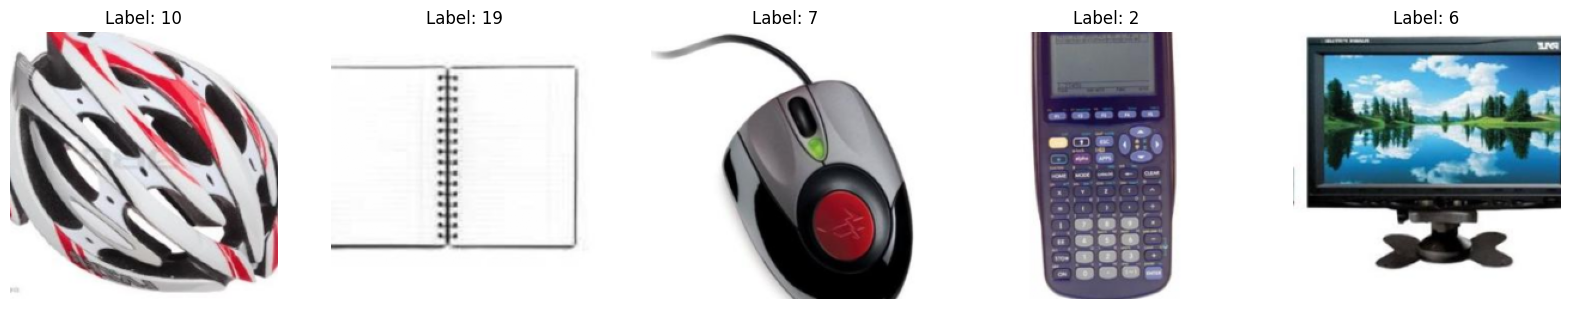

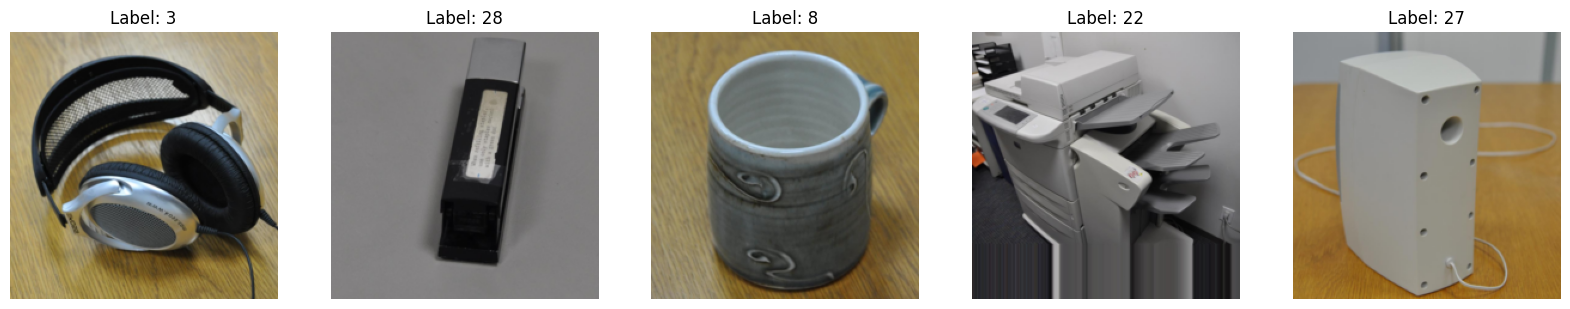

In [9]:
# Visualizing 5 images from a batch
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(im_source[i].permute(1, 2, 0))
    ax[i].set_title(f"Label: {label_source[i]}")
    ax[i].axis('off')
plt.show()

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(im_target[i].permute(1, 2, 0))
    ax[i].set_title(f"Label: {label_target[i]}")
    ax[i].axis('off')
plt.show()

Loading in the UAN model

In [10]:
class BaseFeatureExtractor(nn.Module):
    def forward(self, *input):
        pass

    def __init__(self):
        super(BaseFeatureExtractor, self).__init__()

    def output_num(self):
        pass

    def train(self, mode=True):
        # freeze BN mean and std
        for module in self.children():
            if isinstance(module, nn.BatchNorm2d):
                module.train(False)
            else:
                module.train(mode)


class ResNet50Fc(BaseFeatureExtractor):
    """
    ** input image should be in range of [0, 1]**
    """
    def __init__(self,model_path=None, normalize=True):
        super(ResNet50Fc, self).__init__()
        if model_path:
            if os.path.exists(model_path):
                self.model_resnet = models.resnet50(pretrained=False)
                self.model_resnet.load_state_dict(torch.load(model_path))
            else:
                raise Exception('invalid model path!')
        else:
            print("Using pretrained ImageNet weights")
            self.model_resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        if model_path or normalize:
            # pretrain model is used, use ImageNet normalization
            self.normalize = True
            self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        else:
            self.normalize = False

        model_resnet = self.model_resnet
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool
        self.__in_features = model_resnet.fc.in_features

    def forward(self, x):
        if self.normalize:
            x = (x - self.mean) / self.std
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self.__in_features

class CLS(nn.Module):
    """
    a two-layer MLP for classification
    """
    def __init__(self, in_dim, out_dim, bottle_neck_dim=256):
        super(CLS, self).__init__()
        self.bottleneck = nn.Linear(in_dim, bottle_neck_dim)
        self.fc = nn.Linear(bottle_neck_dim, out_dim)
        self.main = nn.Sequential(self.bottleneck, self.fc, nn.Softmax(dim=-1))

    def forward(self, x):
        out = [x]
        for module in self.main.children():
            x = module(x)
            out.append(x)
        return out


class AdversarialNetwork(nn.Module):
    """
    AdversarialNetwork with a gredient reverse layer.
    its ``forward`` function calls gredient reverse layer first, then applies ``self.main`` module.
    """
    def __init__(self, in_feature):
        super(AdversarialNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_feature, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.grl = GradientReverseModule(lambda step: aToBSheduler(step, 0.0, 1.0, gamma=10, max_iter=10000))

    def forward(self, x):
        x_ = self.grl(x)
        y = self.main(x_)
        return y


In [11]:
model_dict = {
        'resnet50': ResNet50Fc,
    }

class TotalNet(nn.Module):
    def __init__(self):
        super(TotalNet, self).__init__()
        self.feature_extractor = model_dict['resnet50']()
        classifier_output_dim = len(source_classes)
        self.classifier = CLS(self.feature_extractor.output_num(), classifier_output_dim, bottle_neck_dim=256)
        self.discriminator = AdversarialNetwork(256)
        self.discriminator_separate = AdversarialNetwork(256)

    def forward(self, x):
        f = self.feature_extractor(x)
        f, _, __, y = self.classifier(f)
        d = self.discriminator(_)
        d_0 = self.discriminator_separate(_)
        return y, d, d_0


totalNet = TotalNet().to(device)

feature_extractor = totalNet.feature_extractor.train(True)
classifier = totalNet.classifier.train(True)
discriminator = totalNet.discriminator.train(True)
discriminator_separate = totalNet.discriminator_separate.train(True)


# Checking the model architecture
summary(totalNet, input_size=(32, 3, 224, 224))

Using pretrained ImageNet weights


Layer (type:depth-idx)                        Output Shape              Param #
TotalNet                                      [32, 20]                  --
├─ResNet50Fc: 1-1                             [32, 2048]                2,049,000
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]         

Training and testing original

In [12]:
# scheduler = lambda step, initial_lr: inverseDecaySheduler(step, initial_lr, gamma=10, power=0.75, max_iter=10000)
# optimizer_finetune = OptimWithSheduler(
#     optim.SGD(totalNet.feature_extractor.parameters(), lr=lr / 10.0, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)
# optimizer_cls = OptimWithSheduler(
#     optim.SGD(totalNet.classifier.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)
# optimizer_discriminator = OptimWithSheduler(
#     optim.SGD(totalNet.discriminator.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)
# optimizer_discriminator_separate = OptimWithSheduler(
#     optim.SGD(totalNet.discriminator_separate.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)

# global_step = 0
# best_acc = 0

# total_steps = tqdm(range(min_step),desc='global step')
# epoch_id = 0

# while global_step < min_step:

#     iters = tqdm(zip(source_train_dl, target_train_dl), desc=f'epoch {epoch_id} ', total=min(len(source_train_dl), len(target_train_dl)))
#     epoch_id += 1

#     for i, ((im_source, label_source), (im_target, label_target)) in enumerate(iters):

#         save_label_target = label_target  # for debug usage

#         label_source = label_source.to(device)
#         label_target = label_target.to(device)
#         label_target = torch.zeros_like(label_target)

#         # =========================forward pass
#         im_source = im_source.to(device)
#         im_target = im_target.to(device)

#         fc1_s = totalNet.feature_extractor.forward(im_source)
#         fc1_t = totalNet.feature_extractor.forward(im_target)

#         fc1_s, feature_source, fc2_s, predict_prob_source = totalNet.classifier.forward(fc1_s)
#         fc1_t, feature_target, fc2_t, predict_prob_target = totalNet.classifier.forward(fc1_t)

#         domain_prob_discriminator_source = totalNet.discriminator.forward(feature_source)
#         domain_prob_discriminator_target = totalNet.discriminator.forward(feature_target)

#         domain_prob_discriminator_source_separate = totalNet.discriminator_separate.forward(feature_source.detach())
#         domain_prob_discriminator_target_separate = totalNet.discriminator_separate.forward(feature_target.detach())

#         source_share_weight = get_source_share_weight(domain_prob_discriminator_source_separate, fc2_s, domain_temperature=1.0, class_temperature=10.0)
#         source_share_weight = normalize_weight(source_share_weight)
#         target_share_weight = get_target_share_weight(domain_prob_discriminator_target_separate, fc2_t, domain_temperature=1.0, class_temperature=1.0)
#         target_share_weight = normalize_weight(target_share_weight)
            
#         # ==============================compute loss
#         adv_loss = torch.zeros(1, 1).to(device)
#         adv_loss_separate = torch.zeros(1, 1).to(device)

#         tmp = source_share_weight * nn.BCELoss(reduction='none')(domain_prob_discriminator_source, torch.ones_like(domain_prob_discriminator_source))
#         adv_loss += torch.mean(tmp, dim=0, keepdim=True)
#         tmp = target_share_weight * nn.BCELoss(reduction='none')(domain_prob_discriminator_target, torch.zeros_like(domain_prob_discriminator_target))
#         adv_loss += torch.mean(tmp, dim=0, keepdim=True)

#         adv_loss_separate += nn.BCELoss()(domain_prob_discriminator_source_separate, torch.ones_like(domain_prob_discriminator_source_separate))
#         adv_loss_separate += nn.BCELoss()(domain_prob_discriminator_target_separate, torch.zeros_like(domain_prob_discriminator_target_separate))

#         # ============================== cross entropy loss
#         ce = nn.CrossEntropyLoss(reduction='none')(predict_prob_source, label_source)
#         ce = torch.mean(ce, dim=0, keepdim=True)

#         with OptimizerManager(
#                 [optimizer_finetune, optimizer_cls, optimizer_discriminator, optimizer_discriminator_separate]):
#             loss = ce + adv_loss + adv_loss_separate
#             loss.backward()

#         global_step += 1
#         total_steps.update()

#         if global_step % log_interval == 0:
#             counter = AccuracyCounter()
#             counter.addOneBatch(variable_to_numpy(one_hot(label_source, len(source_classes))), variable_to_numpy(predict_prob_source))
#             acc_train = torch.tensor([counter.reportAccuracy()]).to(device)

#             acc_train_func = calculate_accuracy(predict_prob_source, label_source)
#             print(f'adv_loss: {adv_loss.item()}, ce: {ce.item()}, adv_loss_separate: {adv_loss_separate.item()}, acc_train: {acc_train.item()}, acc_train_func: {acc_train_func}')

#         if global_step % test_interval == 0:

#             counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]
#             with TrainingModeManager([totalNet.feature_extractor, totalNet.classifier, totalNet.discriminator_separate], train=False) as mgr, \
#                 Accumulator(['feature', 'predict_prob', 'label', 'domain_prob', 'before_softmax', 'target_share_weight']) as target_accumulator, \
#                 torch.no_grad():

#                 for i, (im, label) in enumerate(tqdm(target_test_dl, desc='testing')):
#                     im = im.to(device)
#                     label = label.to(device)

#                     feature = totalNet.feature_extractor.forward(im)
#                     feature, __, before_softmax, predict_prob = totalNet.classifier.forward(feature)
#                     domain_prob = totalNet.discriminator_separate.forward(__)

#                     target_share_weight = get_target_share_weight(domain_prob, before_softmax, domain_temperature=1.0,
#                                                                 class_temperature=1.0)

#                     for  name in target_accumulator.names:
#                         globals()[name] = variable_to_numpy(globals()[name])

#                     target_accumulator.updateData(globals())

#             for x in target_accumulator:
#                 globals()[x] = target_accumulator[x]

#             def outlier(each_target_share_weight):
#                 return each_target_share_weight < w_0

#             counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]

#             for (each_predict_prob, each_label, each_target_share_weight) in zip(predict_prob, label,
#                                                                                 target_share_weight):
#                 if each_label in source_classes:
#                     counters[each_label].Ntotal += 1.0
#                     each_pred_id = np.argmax(each_predict_prob)
#                     if not outlier(each_target_share_weight[0]) and each_pred_id == each_label:
#                         counters[each_label].Ncorrect += 1.0
#                 else:
#                     counters[-1].Ntotal += 1.0
#                     if outlier(each_target_share_weight[0]):
#                         counters[-1].Ncorrect += 1.0

#             acc_tests = [x.reportAccuracy() for x in counters if not np.isnan(x.reportAccuracy())]
#             acc_test = torch.ones(1, 1) * np.mean(acc_tests)
            
#             print(f'acc_test: {acc_test.item()}')

#             data = {
#                 "feature_extractor": totalNet.feature_extractor.state_dict(),
#                 'classifier': totalNet.classifier.state_dict(),
#                 'discriminator': totalNet.discriminator.state_dict() if not isinstance(discriminator, Nonsense) else 1.0,
#                 'discriminator_separate': totalNet.discriminator_separate.state_dict(),
#             }

#             if acc_test > best_acc:
#                 print(f'best acc test: {acc_test.item()}')
#                 best_acc = acc_test
#                 with open(join(log_dir, 'best.pkl'), 'wb') as f:
#                     torch.save(data, f)

#             with open(join(log_dir, 'current.pkl'), 'wb') as f:
#                 torch.save(data, f)

Training and testing modified

In [13]:
def training_and_testing(totalNet, source_train_dl, target_train_dl, source_test_dl, target_test_dl, log_dir, min_step, log_interval, test_interval, device, source_classes, target_classes):
    # Declaring the scheduler and optimizers
    scheduler = lambda step, initial_lr: inverseDecaySheduler(step, initial_lr, gamma=10, power=0.75, max_iter=10000)
    optimizer_finetune = OptimWithSheduler(
        optim.SGD(totalNet.feature_extractor.parameters(), lr=lr / 10.0, weight_decay=weight_decay, momentum=momentum, nesterov=True),
        scheduler)
    optimizer_cls = OptimWithSheduler(
        optim.SGD(totalNet.classifier.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
        scheduler)
    optimizer_discriminator = OptimWithSheduler(
        optim.SGD(totalNet.discriminator.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
        scheduler)
    optimizer_discriminator_separate = OptimWithSheduler(
        optim.SGD(totalNet.discriminator_separate.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
        scheduler)
    
    global_step = 0
    best_acc = 0

    total_steps = tqdm(range(min_step),desc='global step')
    epoch_id = 0

    while global_step < min_step:

        iters = tqdm(zip(source_train_dl, target_train_dl), desc=f'epoch {epoch_id} ', total=min(len(source_train_dl), len(target_train_dl)))
        epoch_id += 1

        for i, ((im_source, label_source), (im_target, label_target)) in enumerate(iters):

            save_label_target = label_target  # for debug usage

            label_source = label_source.to(device)
            label_target = label_target.to(device)
            label_target = torch.zeros_like(label_target)

            # =========================forward pass
            im_source = im_source.to(device)
            im_target = im_target.to(device)

            fc1_s = totalNet.feature_extractor.forward(im_source)
            fc1_t = totalNet.feature_extractor.forward(im_target)

            fc1_s, feature_source, fc2_s, predict_prob_source = totalNet.classifier.forward(fc1_s)
            fc1_t, feature_target, fc2_t, predict_prob_target = totalNet.classifier.forward(fc1_t)

            domain_prob_discriminator_source = totalNet.discriminator.forward(feature_source)
            domain_prob_discriminator_target = totalNet.discriminator.forward(feature_target)

            domain_prob_discriminator_source_separate = totalNet.discriminator_separate.forward(feature_source.detach())
            domain_prob_discriminator_target_separate = totalNet.discriminator_separate.forward(feature_target.detach())

            source_share_weight = get_source_share_weight(domain_prob_discriminator_source_separate, fc2_s, domain_temperature=1.0, class_temperature=10.0)
            source_share_weight = normalize_weight(source_share_weight)
            target_share_weight = get_target_share_weight(domain_prob_discriminator_target_separate, fc2_t, domain_temperature=1.0, class_temperature=1.0)
            target_share_weight = normalize_weight(target_share_weight)
                
            # ==============================compute loss
            adv_loss = torch.zeros(1, 1).to(device)
            adv_loss_separate = torch.zeros(1, 1).to(device)

            tmp = source_share_weight * nn.BCELoss(reduction='none')(domain_prob_discriminator_source, torch.ones_like(domain_prob_discriminator_source))
            adv_loss += torch.mean(tmp, dim=0, keepdim=True)
            tmp = target_share_weight * nn.BCELoss(reduction='none')(domain_prob_discriminator_target, torch.zeros_like(domain_prob_discriminator_target))
            adv_loss += torch.mean(tmp, dim=0, keepdim=True)

            adv_loss_separate += nn.BCELoss()(domain_prob_discriminator_source_separate, torch.ones_like(domain_prob_discriminator_source_separate))
            adv_loss_separate += nn.BCELoss()(domain_prob_discriminator_target_separate, torch.zeros_like(domain_prob_discriminator_target_separate))

            # ============================== cross entropy loss
            ce = nn.CrossEntropyLoss(reduction='none')(predict_prob_source, label_source)
            ce = torch.mean(ce, dim=0, keepdim=True)

            with OptimizerManager(
                    [optimizer_finetune, optimizer_cls, optimizer_discriminator, optimizer_discriminator_separate]):
                loss = ce + adv_loss + adv_loss_separate
                loss.backward()

            global_step += 1
            total_steps.update()

            if global_step % log_interval == 0:
                counter = AccuracyCounter()
                counter.addOneBatch(variable_to_numpy(one_hot(label_source, len(source_classes))), variable_to_numpy(predict_prob_source))
                acc_train = torch.tensor([counter.reportAccuracy()]).to(device)

                acc_train_func = calculate_accuracy(predict_prob_source, label_source)
                print(f'adv_loss: {adv_loss.item()}, ce: {ce.item()}, adv_loss_separate: {adv_loss_separate.item()}, acc_train: {acc_train.item()}, acc_train_func: {acc_train_func}')

            if global_step % test_interval == 0:

                counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]
                with TrainingModeManager([totalNet.feature_extractor, totalNet.classifier, totalNet.discriminator_separate], train=False) as mgr, \
                    Accumulator(['feature', 'predict_prob', 'label', 'domain_prob', 'before_softmax', 'target_share_weight']) as target_accumulator, \
                    torch.no_grad():

                    for i, (im, label) in enumerate(tqdm(target_test_dl, desc='testing')):
                        im = im.to(device)
                        label = label.to(device)

                        feature = totalNet.feature_extractor.forward(im)
                        feature, __, before_softmax, predict_prob = totalNet.classifier.forward(feature)
                        domain_prob = totalNet.discriminator_separate.forward(__)

                        target_share_weight = get_target_share_weight(domain_prob, before_softmax, domain_temperature=1.0,
                                                                    class_temperature=1.0)
                        
                        globals().update({
                            'feature': variable_to_numpy(feature),
                            'predict_prob': variable_to_numpy(predict_prob),
                            'label': variable_to_numpy(label),
                            'domain_prob': variable_to_numpy(domain_prob),
                            'before_softmax': variable_to_numpy(before_softmax),
                            'target_share_weight': variable_to_numpy(target_share_weight),
                        })

                        target_accumulator.updateData(globals())

                for x in target_accumulator:
                    globals()[x] = target_accumulator[x]

                def outlier(each_target_share_weight):
                    return each_target_share_weight < w_0

                counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]

                for (each_predict_prob, each_label, each_target_share_weight) in zip(predict_prob, label,
                                                                                    target_share_weight):
                    if each_label in source_classes:
                        counters[each_label].Ntotal += 1.0
                        each_pred_id = np.argmax(each_predict_prob)
                        if not outlier(each_target_share_weight[0]) and each_pred_id == each_label:
                            counters[each_label].Ncorrect += 1.0
                    else:
                        counters[-1].Ntotal += 1.0
                        if outlier(each_target_share_weight[0]):
                            counters[-1].Ncorrect += 1.0

                acc_tests = [x.reportAccuracy() for x in counters if not np.isnan(x.reportAccuracy())]
                acc_test = torch.ones(1, 1) * np.mean(acc_tests)
                
                print(f'acc_test: {acc_test.item()}')

                data = {
                    "feature_extractor": totalNet.feature_extractor.state_dict(),
                    'classifier': totalNet.classifier.state_dict(),
                    'discriminator': totalNet.discriminator.state_dict() if not isinstance(discriminator, Nonsense) else 1.0,
                    'discriminator_separate': totalNet.discriminator_separate.state_dict(),
                }

                if acc_test > best_acc:
                    print(f'best acc test: {acc_test.item()}')
                    best_acc = acc_test
                    with open(join(log_dir, 'best.pkl'), 'wb') as f:
                        torch.save(data, f)

                with open(join(log_dir, 'current.pkl'), 'wb') as f:
                    torch.save(data, f)

In [14]:
# Training and testing the model
training_and_testing(totalNet, source_train_dl, target_train_dl, source_test_dl, target_test_dl, log_dir, min_step, log_interval, test_interval, device, source_classes, target_classes)

global step:   0%|          | 0/100 [00:00<?, ?it/s]

global step:   1%|          | 1/100 [00:16<27:26, 16.63s/it]

adv_loss: 1.38446843624115, ce: 2.9963927268981934, adv_loss_separate: 1.3850288391113281, acc_train: 0.0, acc_train_func: 0.0


global step:   2%|▏         | 2/100 [00:33<27:06, 16.60s/it]

adv_loss: 1.3854683637619019, ce: 2.994960308074951, adv_loss_separate: 1.389029622077942, acc_train: 0.125, acc_train_func: 0.125


global step:   3%|▎         | 3/100 [00:50<26:59, 16.70s/it]

adv_loss: 1.3837462663650513, ce: 2.9973502159118652, adv_loss_separate: 1.382136583328247, acc_train: 0.09375, acc_train_func: 0.09375


global step:   4%|▍         | 4/100 [01:08<27:32, 17.21s/it]

adv_loss: 1.3828222751617432, ce: 2.9957666397094727, adv_loss_separate: 1.386955976486206, acc_train: 0.0, acc_train_func: 0.0


global step:   5%|▌         | 5/100 [01:25<27:35, 17.43s/it]

adv_loss: 1.3875887393951416, ce: 2.9945709705352783, adv_loss_separate: 1.386902093887329, acc_train: 0.0625, acc_train_func: 0.0625


global step:   6%|▌         | 6/100 [01:43<27:38, 17.64s/it]

adv_loss: 1.3801957368850708, ce: 2.995828628540039, adv_loss_separate: 1.3845384120941162, acc_train: 0.0625, acc_train_func: 0.0625


global step:   7%|▋         | 7/100 [02:02<27:59, 18.06s/it]

adv_loss: 1.389443278312683, ce: 2.994882822036743, adv_loss_separate: 1.3861029148101807, acc_train: 0.15625, acc_train_func: 0.15625


global step:   8%|▊         | 8/100 [02:21<28:00, 18.26s/it]

adv_loss: 1.389981985092163, ce: 2.9964284896850586, adv_loss_separate: 1.384706735610962, acc_train: 0.0625, acc_train_func: 0.0625


global step:   9%|▉         | 9/100 [02:41<28:19, 18.67s/it]

adv_loss: 1.3799906969070435, ce: 2.9941494464874268, adv_loss_separate: 1.388753890991211, acc_train: 0.125, acc_train_func: 0.125


global step:  10%|█         | 10/100 [03:01<28:36, 19.07s/it]

adv_loss: 1.3872175216674805, ce: 2.995272397994995, adv_loss_separate: 1.3921923637390137, acc_train: 0.125, acc_train_func: 0.125














testing: 100%|██████████| 11/11 [00:55<00:00,  5.09s/it]


acc_test: 0.0


global step:  11%|█         | 11/100 [04:18<54:42, 36.88s/it]

adv_loss: 1.385727882385254, ce: 2.9948878288269043, adv_loss_separate: 1.3850622177124023, acc_train: 0.09375, acc_train_func: 0.09375


global step:  12%|█▏        | 12/100 [04:38<46:49, 31.92s/it]

adv_loss: 1.381836175918579, ce: 2.9962992668151855, adv_loss_separate: 1.3888791799545288, acc_train: 0.0, acc_train_func: 0.0


global step:  13%|█▎        | 13/100 [04:59<41:12, 28.42s/it]

adv_loss: 1.384920597076416, ce: 2.9966812133789062, adv_loss_separate: 1.3807154893875122, acc_train: 0.03125, acc_train_func: 0.03125


global step:  14%|█▍        | 14/100 [05:18<36:54, 25.75s/it]

adv_loss: 1.3891955614089966, ce: 2.994729518890381, adv_loss_separate: 1.3863186836242676, acc_train: 0.125, acc_train_func: 0.125


global step:  15%|█▌        | 15/100 [05:38<33:50, 23.89s/it]

adv_loss: 1.381932258605957, ce: 2.995488166809082, adv_loss_separate: 1.3813929557800293, acc_train: 0.09375, acc_train_func: 0.09375


global step:  16%|█▌        | 16/100 [05:58<31:51, 22.75s/it]

adv_loss: 1.3854846954345703, ce: 2.9954895973205566, adv_loss_separate: 1.3930039405822754, acc_train: 0.09375, acc_train_func: 0.09375


global step:  17%|█▋        | 17/100 [06:18<30:15, 21.88s/it]

adv_loss: 1.3766119480133057, ce: 2.997194290161133, adv_loss_separate: 1.3827630281448364, acc_train: 0.0, acc_train_func: 0.0


global step:  18%|█▊        | 18/100 [06:38<29:12, 21.37s/it]

adv_loss: 1.3873438835144043, ce: 2.9967169761657715, adv_loss_separate: 1.390435814857483, acc_train: 0.03125, acc_train_func: 0.03125


global step:  19%|█▉        | 19/100 [06:59<28:38, 21.22s/it]

adv_loss: 1.3904197216033936, ce: 2.9953720569610596, adv_loss_separate: 1.3867926597595215, acc_train: 0.0, acc_train_func: 0.0


global step:  20%|██        | 20/100 [07:20<28:15, 21.19s/it]

adv_loss: 1.3882004022598267, ce: 2.9938113689422607, adv_loss_separate: 1.3809795379638672, acc_train: 0.0625, acc_train_func: 0.0625














testing: 100%|██████████| 11/11 [01:00<00:00,  5.46s/it]


acc_test: 0.0


global step:  21%|██        | 21/100 [08:43<52:13, 39.67s/it]

adv_loss: 1.3935667276382446, ce: 2.9952754974365234, adv_loss_separate: 1.3840652704238892, acc_train: 0.03125, acc_train_func: 0.03125


global step:  22%|██▏       | 22/100 [09:05<44:48, 34.46s/it]

adv_loss: 1.3822112083435059, ce: 2.9954147338867188, adv_loss_separate: 1.3841798305511475, acc_train: 0.09375, acc_train_func: 0.09375


global step:  23%|██▎       | 23/100 [09:27<39:16, 30.60s/it]

adv_loss: 1.3750193119049072, ce: 2.9938464164733887, adv_loss_separate: 1.3811500072479248, acc_train: 0.125, acc_train_func: 0.125


global step:  24%|██▍       | 24/100 [09:49<35:45, 28.23s/it]

adv_loss: 1.3840878009796143, ce: 2.9956212043762207, adv_loss_separate: 1.380237102508545, acc_train: 0.0625, acc_train_func: 0.0625


global step:  25%|██▌       | 25/100 [10:12<33:10, 26.55s/it]

adv_loss: 1.3897984027862549, ce: 2.9949471950531006, adv_loss_separate: 1.3864378929138184, acc_train: 0.15625, acc_train_func: 0.15625


global step:  26%|██▌       | 26/100 [10:34<31:02, 25.17s/it]

adv_loss: 1.3890509605407715, ce: 2.994805335998535, adv_loss_separate: 1.3800609111785889, acc_train: 0.09375, acc_train_func: 0.09375


global step:  27%|██▋       | 27/100 [10:55<29:16, 24.06s/it]

adv_loss: 1.3807889223098755, ce: 2.994877338409424, adv_loss_separate: 1.390716791152954, acc_train: 0.09375, acc_train_func: 0.09375


global step:  28%|██▊       | 28/100 [11:17<27:57, 23.30s/it]

adv_loss: 1.3768703937530518, ce: 2.9966728687286377, adv_loss_separate: 1.3806228637695312, acc_train: 0.09375, acc_train_func: 0.09375


global step:  29%|██▉       | 29/100 [11:38<26:44, 22.60s/it]

adv_loss: 1.3845465183258057, ce: 2.9945764541625977, adv_loss_separate: 1.3803095817565918, acc_train: 0.09375, acc_train_func: 0.09375


global step:  30%|███       | 30/100 [12:00<26:03, 22.33s/it]

adv_loss: 1.3882725238800049, ce: 2.997332811355591, adv_loss_separate: 1.3841795921325684, acc_train: 0.03125, acc_train_func: 0.03125














testing: 100%|██████████| 11/11 [00:58<00:00,  5.34s/it]


acc_test: 0.0


global step:  31%|███       | 31/100 [13:19<45:31, 39.58s/it]

adv_loss: 1.3804831504821777, ce: 2.9957196712493896, adv_loss_separate: 1.3899787664413452, acc_train: 0.0625, acc_train_func: 0.0625


global step:  32%|███▏      | 32/100 [13:40<38:27, 33.93s/it]

adv_loss: 1.3802416324615479, ce: 2.995380401611328, adv_loss_separate: 1.377880334854126, acc_train: 0.09375, acc_train_func: 0.09375


global step:  33%|███▎      | 33/100 [14:01<33:31, 30.02s/it]

adv_loss: 1.3898829221725464, ce: 2.9961023330688477, adv_loss_separate: 1.38399338722229, acc_train: 0.125, acc_train_func: 0.125


global step:  34%|███▍      | 34/100 [14:21<29:39, 26.97s/it]

adv_loss: 1.3859835863113403, ce: 2.9960954189300537, adv_loss_separate: 1.3828781843185425, acc_train: 0.09375, acc_train_func: 0.09375


global step:  35%|███▌      | 35/100 [14:42<27:13, 25.13s/it]

adv_loss: 1.3807933330535889, ce: 2.995769500732422, adv_loss_separate: 1.382948398590088, acc_train: 0.03125, acc_train_func: 0.03125


global step:  36%|███▌      | 36/100 [15:02<25:12, 23.63s/it]

adv_loss: 1.3829121589660645, ce: 2.9946017265319824, adv_loss_separate: 1.3822460174560547, acc_train: 0.09375, acc_train_func: 0.09375


global step:  37%|███▋      | 37/100 [15:23<23:53, 22.76s/it]

adv_loss: 1.3830007314682007, ce: 2.9964098930358887, adv_loss_separate: 1.388493537902832, acc_train: 0.0625, acc_train_func: 0.0625


global step:  38%|███▊      | 38/100 [15:43<22:52, 22.13s/it]

adv_loss: 1.3821446895599365, ce: 2.995278835296631, adv_loss_separate: 1.3881676197052002, acc_train: 0.09375, acc_train_func: 0.09375


global step:  39%|███▉      | 39/100 [16:04<22:00, 21.65s/it]

adv_loss: 1.3823339939117432, ce: 2.995469093322754, adv_loss_separate: 1.393836259841919, acc_train: 0.0625, acc_train_func: 0.0625


global step:  40%|████      | 40/100 [16:25<21:25, 21.43s/it]

adv_loss: 1.3860714435577393, ce: 2.995084047317505, adv_loss_separate: 1.3799529075622559, acc_train: 0.21875, acc_train_func: 0.21875














testing: 100%|██████████| 11/11 [00:59<00:00,  5.39s/it]


acc_test: 0.0


global step:  41%|████      | 41/100 [17:45<38:24, 39.05s/it]

adv_loss: 1.3871982097625732, ce: 2.9953577518463135, adv_loss_separate: 1.3870688676834106, acc_train: 0.09375, acc_train_func: 0.09375


global step:  42%|████▏     | 42/100 [18:06<32:30, 33.62s/it]

adv_loss: 1.3825416564941406, ce: 2.9948134422302246, adv_loss_separate: 1.3891689777374268, acc_train: 0.09375, acc_train_func: 0.09375


global step:  43%|████▎     | 43/100 [18:28<28:37, 30.13s/it]

adv_loss: 1.3871593475341797, ce: 2.9950814247131348, adv_loss_separate: 1.384976863861084, acc_train: 0.09375, acc_train_func: 0.09375


global step:  44%|████▍     | 44/100 [18:48<25:23, 27.21s/it]

adv_loss: 1.3826863765716553, ce: 2.996385097503662, adv_loss_separate: 1.3838353157043457, acc_train: 0.0625, acc_train_func: 0.0625


global step:  45%|████▌     | 45/100 [19:08<23:00, 25.11s/it]

adv_loss: 1.386217474937439, ce: 2.9951839447021484, adv_loss_separate: 1.3827422857284546, acc_train: 0.0625, acc_train_func: 0.0625


global step:  46%|████▌     | 46/100 [19:30<21:36, 24.00s/it]

adv_loss: 1.3883459568023682, ce: 2.9965710639953613, adv_loss_separate: 1.3874411582946777, acc_train: 0.125, acc_train_func: 0.125


global step:  47%|████▋     | 47/100 [19:51<20:30, 23.22s/it]

adv_loss: 1.3869965076446533, ce: 2.9963278770446777, adv_loss_separate: 1.3867651224136353, acc_train: 0.03125, acc_train_func: 0.03125


global step:  48%|████▊     | 48/100 [20:12<19:29, 22.49s/it]

adv_loss: 1.3838517665863037, ce: 2.994117259979248, adv_loss_separate: 1.3824703693389893, acc_train: 0.0625, acc_train_func: 0.0625


global step:  49%|████▉     | 49/100 [20:33<18:49, 22.15s/it]

adv_loss: 1.3809020519256592, ce: 2.9947140216827393, adv_loss_separate: 1.3864206075668335, acc_train: 0.125, acc_train_func: 0.125


global step:  50%|█████     | 50/100 [20:55<18:13, 21.86s/it]

adv_loss: 1.389794111251831, ce: 2.995767593383789, adv_loss_separate: 1.3889594078063965, acc_train: 0.03125, acc_train_func: 0.03125














testing: 100%|██████████| 11/11 [00:59<00:00,  5.44s/it]


acc_test: 0.0


global step:  51%|█████     | 51/100 [22:15<32:16, 39.52s/it]

adv_loss: 1.3844571113586426, ce: 2.993143081665039, adv_loss_separate: 1.3865516185760498, acc_train: 0.15625, acc_train_func: 0.15625


global step:  52%|█████▏    | 52/100 [22:36<27:11, 34.00s/it]

adv_loss: 1.3894546031951904, ce: 2.995441436767578, adv_loss_separate: 1.3850926160812378, acc_train: 0.0625, acc_train_func: 0.0625


global step:  53%|█████▎    | 53/100 [22:58<23:39, 30.20s/it]

adv_loss: 1.376805067062378, ce: 2.994925022125244, adv_loss_separate: 1.3823955059051514, acc_train: 0.0, acc_train_func: 0.0


global step:  54%|█████▍    | 54/100 [23:19<20:58, 27.36s/it]

adv_loss: 1.3878556489944458, ce: 2.9951813220977783, adv_loss_separate: 1.387960433959961, acc_train: 0.09375, acc_train_func: 0.09375


global step:  55%|█████▌    | 55/100 [23:39<19:04, 25.42s/it]

adv_loss: 1.3879965543746948, ce: 2.9957082271575928, adv_loss_separate: 1.3873025178909302, acc_train: 0.09375, acc_train_func: 0.09375


global step:  56%|█████▌    | 56/100 [24:01<17:41, 24.13s/it]

adv_loss: 1.3858436346054077, ce: 2.995147466659546, adv_loss_separate: 1.384307861328125, acc_train: 0.09375, acc_train_func: 0.09375


global step:  57%|█████▋    | 57/100 [24:21<16:25, 22.91s/it]

adv_loss: 1.3825502395629883, ce: 2.9956300258636475, adv_loss_separate: 1.382479190826416, acc_train: 0.0625, acc_train_func: 0.0625


global step:  58%|█████▊    | 58/100 [24:41<15:27, 22.09s/it]

adv_loss: 1.3886768817901611, ce: 2.994114398956299, adv_loss_separate: 1.393115520477295, acc_train: 0.0625, acc_train_func: 0.0625


global step:  59%|█████▉    | 59/100 [25:02<14:49, 21.70s/it]

adv_loss: 1.386554479598999, ce: 2.994886875152588, adv_loss_separate: 1.3835866451263428, acc_train: 0.1875, acc_train_func: 0.1875


global step:  60%|██████    | 60/100 [25:23<14:30, 21.76s/it]

adv_loss: 1.3789634704589844, ce: 2.9958202838897705, adv_loss_separate: 1.3834556341171265, acc_train: 0.15625, acc_train_func: 0.15625














testing: 100%|██████████| 11/11 [01:00<00:00,  5.48s/it]


acc_test: 0.0


global step:  61%|██████    | 61/100 [26:45<25:43, 39.58s/it]

adv_loss: 1.3936206102371216, ce: 2.995229482650757, adv_loss_separate: 1.3854799270629883, acc_train: 0.0625, acc_train_func: 0.0625


global step:  62%|██████▏   | 62/100 [27:06<21:31, 33.98s/it]

adv_loss: 1.3830300569534302, ce: 2.995011329650879, adv_loss_separate: 1.3844761848449707, acc_train: 0.09375, acc_train_func: 0.09375


global step:  63%|██████▎   | 63/100 [27:26<18:29, 29.98s/it]

adv_loss: 1.3840043544769287, ce: 2.996055841445923, adv_loss_separate: 1.3834407329559326, acc_train: 0.0625, acc_train_func: 0.0625


global step:  64%|██████▍   | 64/100 [27:48<16:33, 27.60s/it]

adv_loss: 1.3847482204437256, ce: 2.9951963424682617, adv_loss_separate: 1.3882436752319336, acc_train: 0.09375, acc_train_func: 0.09375


global step:  65%|██████▌   | 65/100 [28:09<14:57, 25.66s/it]

adv_loss: 1.3886804580688477, ce: 2.9961535930633545, adv_loss_separate: 1.3866820335388184, acc_train: 0.09375, acc_train_func: 0.09375


global step:  66%|██████▌   | 66/100 [28:31<13:51, 24.45s/it]

adv_loss: 1.3880455493927002, ce: 2.9955673217773438, adv_loss_separate: 1.3833255767822266, acc_train: 0.03125, acc_train_func: 0.03125


global step:  67%|██████▋   | 67/100 [28:52<12:52, 23.40s/it]

adv_loss: 1.3806989192962646, ce: 2.996537208557129, adv_loss_separate: 1.3850995302200317, acc_train: 0.03125, acc_train_func: 0.03125


global step:  68%|██████▊   | 68/100 [29:13<12:05, 22.66s/it]

adv_loss: 1.384204387664795, ce: 2.9949865341186523, adv_loss_separate: 1.3877313137054443, acc_train: 0.15625, acc_train_func: 0.15625


global step:  69%|██████▉   | 69/100 [29:34<11:28, 22.22s/it]

adv_loss: 1.3821979761123657, ce: 2.9942259788513184, adv_loss_separate: 1.3899638652801514, acc_train: 0.0625, acc_train_func: 0.0625


global step:  70%|███████   | 70/100 [29:56<11:04, 22.15s/it]

adv_loss: 1.3882777690887451, ce: 2.9936883449554443, adv_loss_separate: 1.384093999862671, acc_train: 0.09375, acc_train_func: 0.09375














testing: 100%|██████████| 11/11 [01:00<00:00,  5.53s/it]


acc_test: 0.0


global step:  71%|███████   | 71/100 [31:19<19:29, 40.34s/it]

adv_loss: 1.3782254457473755, ce: 2.995729684829712, adv_loss_separate: 1.3868426084518433, acc_train: 0.0625, acc_train_func: 0.0625


global step:  72%|███████▏  | 72/100 [31:40<16:07, 34.56s/it]

adv_loss: 1.3869627714157104, ce: 2.995434522628784, adv_loss_separate: 1.3878662586212158, acc_train: 0.15625, acc_train_func: 0.15625


global step:  73%|███████▎  | 73/100 [32:01<13:47, 30.67s/it]

adv_loss: 1.391213297843933, ce: 2.995148181915283, adv_loss_separate: 1.3803523778915405, acc_train: 0.0625, acc_train_func: 0.0625


global step:  74%|███████▍  | 74/100 [32:23<12:03, 27.81s/it]

adv_loss: 1.3872432708740234, ce: 2.9954683780670166, adv_loss_separate: 1.3835961818695068, acc_train: 0.03125, acc_train_func: 0.03125


global step:  75%|███████▌  | 75/100 [32:44<10:45, 25.82s/it]

adv_loss: 1.383311152458191, ce: 2.996345281600952, adv_loss_separate: 1.3818645477294922, acc_train: 0.0, acc_train_func: 0.0


global step:  76%|███████▌  | 76/100 [33:05<09:48, 24.51s/it]

adv_loss: 1.3866406679153442, ce: 2.995291233062744, adv_loss_separate: 1.3878726959228516, acc_train: 0.0625, acc_train_func: 0.0625


global step:  77%|███████▋  | 77/100 [33:27<09:04, 23.66s/it]

adv_loss: 1.3867928981781006, ce: 2.9948577880859375, adv_loss_separate: 1.3860828876495361, acc_train: 0.09375, acc_train_func: 0.09375


global step:  78%|███████▊  | 78/100 [33:49<08:30, 23.19s/it]

adv_loss: 1.385615348815918, ce: 2.9945247173309326, adv_loss_separate: 1.3879631757736206, acc_train: 0.125, acc_train_func: 0.125


global step:  79%|███████▉  | 79/100 [34:10<07:52, 22.52s/it]

adv_loss: 1.3884589672088623, ce: 2.9931230545043945, adv_loss_separate: 1.3829166889190674, acc_train: 0.15625, acc_train_func: 0.15625


global step:  80%|████████  | 80/100 [34:32<07:30, 22.50s/it]

adv_loss: 1.3851443529129028, ce: 2.995722532272339, adv_loss_separate: 1.380237340927124, acc_train: 0.15625, acc_train_func: 0.15625














testing: 100%|██████████| 11/11 [01:01<00:00,  5.58s/it]


acc_test: 0.0


global step:  81%|████████  | 81/100 [35:56<12:57, 40.94s/it]

adv_loss: 1.389320731163025, ce: 2.9933385848999023, adv_loss_separate: 1.3878628015518188, acc_train: 0.21875, acc_train_func: 0.21875


global step:  82%|████████▏ | 82/100 [36:17<10:28, 34.91s/it]

adv_loss: 1.389378309249878, ce: 2.9941463470458984, adv_loss_separate: 1.3749016523361206, acc_train: 0.21875, acc_train_func: 0.21875


global step:  83%|████████▎ | 83/100 [36:39<08:46, 30.99s/it]

adv_loss: 1.3839324712753296, ce: 2.9946913719177246, adv_loss_separate: 1.3821606636047363, acc_train: 0.15625, acc_train_func: 0.15625


global step:  84%|████████▍ | 84/100 [37:00<07:29, 28.09s/it]

adv_loss: 1.380415916442871, ce: 2.9939723014831543, adv_loss_separate: 1.382840633392334, acc_train: 0.09375, acc_train_func: 0.09375


global step:  85%|████████▌ | 85/100 [37:21<06:28, 25.89s/it]

adv_loss: 1.3880406618118286, ce: 2.9963481426239014, adv_loss_separate: 1.3829216957092285, acc_train: 0.125, acc_train_func: 0.125


global step:  86%|████████▌ | 86/100 [37:42<05:42, 24.43s/it]

adv_loss: 1.3822758197784424, ce: 2.9949851036071777, adv_loss_separate: 1.3819737434387207, acc_train: 0.15625, acc_train_func: 0.15625


global step:  87%|████████▋ | 87/100 [38:03<05:04, 23.44s/it]

adv_loss: 1.3768260478973389, ce: 2.9949417114257812, adv_loss_separate: 1.3888792991638184, acc_train: 0.09375, acc_train_func: 0.09375


global step:  88%|████████▊ | 88/100 [38:26<04:36, 23.06s/it]

adv_loss: 1.3856950998306274, ce: 2.9947783946990967, adv_loss_separate: 1.3811520338058472, acc_train: 0.125, acc_train_func: 0.125


global step:  89%|████████▉ | 89/100 [38:47<04:07, 22.54s/it]

adv_loss: 1.388913869857788, ce: 2.996056079864502, adv_loss_separate: 1.387604832649231, acc_train: 0.0625, acc_train_func: 0.0625


global step:  90%|█████████ | 90/100 [39:09<03:43, 22.31s/it]

adv_loss: 1.3876579999923706, ce: 2.994615316390991, adv_loss_separate: 1.3803967237472534, acc_train: 0.09375, acc_train_func: 0.09375














testing: 100%|██████████| 11/11 [01:00<00:00,  5.52s/it]


acc_test: 0.0


global step:  91%|█████████ | 91/100 [40:32<06:04, 40.49s/it]

adv_loss: 1.384347915649414, ce: 2.993959903717041, adv_loss_separate: 1.384326696395874, acc_train: 0.21875, acc_train_func: 0.21875


global step:  92%|█████████▏| 92/100 [40:52<04:36, 34.57s/it]

adv_loss: 1.3832738399505615, ce: 2.9931418895721436, adv_loss_separate: 1.3888086080551147, acc_train: 0.1875, acc_train_func: 0.1875


global step:  93%|█████████▎| 93/100 [41:13<03:32, 30.35s/it]

adv_loss: 1.3824546337127686, ce: 2.9955310821533203, adv_loss_separate: 1.378814697265625, acc_train: 0.15625, acc_train_func: 0.15625


global step:  94%|█████████▍| 94/100 [41:35<02:46, 27.82s/it]

adv_loss: 1.384570837020874, ce: 2.994373321533203, adv_loss_separate: 1.383180856704712, acc_train: 0.15625, acc_train_func: 0.15625


global step:  95%|█████████▌| 95/100 [41:57<02:11, 26.30s/it]

adv_loss: 1.3837227821350098, ce: 2.9969067573547363, adv_loss_separate: 1.3865971565246582, acc_train: 0.0625, acc_train_func: 0.0625


global step:  96%|█████████▌| 96/100 [42:20<01:40, 25.03s/it]

adv_loss: 1.3819575309753418, ce: 2.995466947555542, adv_loss_separate: 1.3854343891143799, acc_train: 0.125, acc_train_func: 0.125


global step:  97%|█████████▋| 97/100 [42:41<01:12, 24.10s/it]

adv_loss: 1.3833391666412354, ce: 2.994528293609619, adv_loss_separate: 1.3820602893829346, acc_train: 0.09375, acc_train_func: 0.09375


global step:  98%|█████████▊| 98/100 [43:03<00:46, 23.48s/it]

adv_loss: 1.394364595413208, ce: 2.995521306991577, adv_loss_separate: 1.3836231231689453, acc_train: 0.0625, acc_train_func: 0.0625


global step:  99%|█████████▉| 99/100 [43:25<00:22, 22.96s/it]

adv_loss: 1.3837668895721436, ce: 2.994882345199585, adv_loss_separate: 1.3840978145599365, acc_train: 0.15625, acc_train_func: 0.15625


global step: 100%|██████████| 100/100 [43:46<00:00, 22.42s/it]

adv_loss: 1.3871548175811768, ce: 2.994030714035034, adv_loss_separate: 1.381678581237793, acc_train: 0.1875, acc_train_func: 0.1875














testing: 100%|██████████| 11/11 [01:04<00:00,  5.88s/it]


acc_test: 0.0


global step: 100%|██████████| 100/100 [44:51<00:00, 26.92s/it]
